# Diagnostic Sender Classificatio to Probe Co-Adaptation

## Importing the Required Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import csv
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preparing the Evaluation Data

In [2]:
def load_eval_data(eval_data_path, comm_size):
    '''
    load_eval_data opens the given evaluation data and uses it to produce a dataset for training and testing the diagnostic classifier.
    
    Parameter:
        eval_data_path -- Path of the evaluation data
        comm_size -- The community size and therefore the number of different senders
    
    Output:
        Dataset as list of tuples (message, sender_idx)
            message -- Tensor of one-hot encoded message symbols in size (message length, vocab size)
            label --  One-hot encoded imagenet class of target image
    '''
    output_data = [] 
    with open(eval_data_path, 'r') as eval_data:
        reader = csv.reader(eval_data)
        for i,line in enumerate(reader):
            for sender_idx in range(comm_size):
                if i > 0:
                    # the message's symbols are one-hot encoded and a message in gru compatible format is produced from these one-hot encodings,
                    # i.e. in a tensor of shape(sequence_len, input_size) which in my case is (message_len+1,vocab_size) = (6,10)
                    message = [int(symbol) for symbol in line[4+sender_idx].split(',')]
                    symbols_one_hot = []
                    for symbol in message:
                        symbols_one_hot.append(list(F.one_hot(torch.tensor(symbol), num_classes = 10)))
                    message_gru_compatible = torch.tensor(symbols_one_hot).type(torch.FloatTensor)
                    # the label is one-hot encoded as well
                    sender_idx_one_hot = F.one_hot(torch.tensor(sender_idx), comm_size).type(torch.FloatTensor)
                    # gru compatible message and one-hot encoded label, are stored as the datasets input and target
                    output_data.append((message_gru_compatible, sender_idx_one_hot))
                
    return output_data

In [3]:
class Diagn_Dataset(Dataset):
    '''
    A PyTorch compatible dataset for training, validating and testing the diagnostic classifier of a sender
    
    Attributes:
        frame -- The dataset
    
    Methods:
        __init__(eval_data_path, sender_idx) -- Creates an object of the class
        __len__() -- Returns the length 
        __getitem__(idx) -- Returns a sample from frame by index
    '''
    def __init__(self, eval_data_path, comm_size):
        '''
        Intializes an object of the Diagn_Dataset class by filling the frame attribute with the output of a load_eval_data() call.
        
        Parameter:
            eval_data_path -- Path to the evaluation data to be used
            comm_size -- The community size and therefore the number of different senders
        
        Output:
            None
        '''
        super(Dataset, self).__init__()
        self.frame = load_eval_data(eval_data_path, comm_size)
    
    def __len__(self):
        'Returns the length of the dataset.'
        return len(self.frame)

    def __getitem__(self, idx):
        '''
        Returns an entry of the dataset by index.
        
        Parameter:
            idx -- Index of the the requested entry
            
        Output:
            Entry of the dataset in the form (message, label)
        '''
        return self.frame[idx]

## The Diagnostic Classifier

In [4]:
class Diagnostic_Classifier(nn.Module):
    '''
    A diagnostic classifier, i.e. a neural network, to be used for evaluating concept encoding of a sender.
    
    Attributes:
        gru -- The first layer of the network, a GRU cell
        fc -- The second layer of the network, a fully connected layer
        output -- The output layer of the network, a fully connected layer
    
    Methods:
        __init__(input_dim = 10, output_dim = 1000, gru_hidden = 10) -- Creates an object of the class
        forward(x) -- Computes the output of the network given input x
    '''
    def __init__(self, output_dim, input_dim = 10,gru_hidden = 10):
        '''
        Initializes a class object by initializing its attributes.
        
        Parameter:
            input_dim -- Input dimension of the first layer, the GRU cell (default: 10)
            outptu_dim -- Dimension of the output tensor, should be equal to nr of classes (default: 1000)
            gru_hidden -- Size of the GRU's hidden state (default = 10)
        
        Output:
            None
        '''
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first = True)
        self.fc = nn.Linear(gru_hidden, 512)
        self.output = nn.Linear(512, output_dim)
    
    def forward(self, x):
        '''
        Computes the output of the network when given input x.
        
        Parameter:
            x - Input, a representation of a message
        
        Output:
            A tensor in the dimesnion of number of classes, the element with the highest activation represents the networks class predicition
        '''
        # can provide gru 2nd input (init hidden state), defaults to zeros
        _, x = self.gru(x)
        x = self.fc(x.squeeze())
        x = self.output(x)
        return x

## Sender Classification for All Communities

In [5]:
# the community sizes to be evaluated
comm_sizes = [2,4]
seeds = [1,2,3,4,5]
# list to store the accuracies for each community size (averaged over senders)
avg_losses = []
losses = []
avg_accs = []
accs = []

# parameters for training the diagnostic classifiers
num_epochs = 30
batch_size = 256
learning_rate = 0.001

# evaluating each community size
for comm_size in comm_sizes:
    comm_accs = []
    comm_losses = []
    for seed in seeds:
        eval_data_path = './Data/Evaluation_Data/Comm_Size_'+ str(comm_size) +'/Seed_'+str(seed)+'/evaluation_data.csv'

        # initializing the diagnostic classifier
        diagn_classifier = Diagnostic_Classifier(output_dim = comm_size).to(device)
        # loading the evaluation data and splitting in a train and test set
        # using generator for splitting to make sure all classifiers get train and test data from the same game interactions
        data = Diagn_Dataset(eval_data_path, comm_size)

        train_data_len = int(len(data) * 0.5)
        test_data_len = len(data) - train_data_len

        train_data, test_data = torch.utils.data.random_split(data, [train_data_len, test_data_len], generator=torch.Generator().manual_seed(42))
        
        trainloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1)
        testloader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 1)

        # defining the loss criterion and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(diagn_classifier.parameters(), lr=learning_rate)
        
        # training diagnostic classifier for current sender
        for epoch in range(num_epochs):
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(trainloader, 0):
                optimizer.zero_grad()
                outputs = diagn_classifier(inputs.to(device))
                loss = criterion(outputs, labels.to(device))
                loss.backward()
                optimizer.step()

        # evaluating the diagnostic classifiers performance on the test data
        total = 0
        correct = 0
        total_loss = 0
        with torch.no_grad():
            for (inputs, labels) in testloader:
                outputs = diagn_classifier(inputs.to(device))
                _, predicted = torch.max(outputs.data, 1)
                _, targets = torch.max(labels, 1)
                total += labels.size(0)
                correct += (predicted == targets.to(device)).sum().item()
                total_loss += criterion(outputs, labels.to(device)).item()
        
        comm_accs.append((correct/total))
        comm_losses.append((total_loss/total))

    avg_losses.append(np.array(comm_losses).mean())
    losses.append(comm_losses)
    avg_accs.append(np.array(comm_accs).mean())
    accs.append(comm_accs)

In [6]:
print('Num Epochs: ', num_epochs, '   Batch Size: ', batch_size, '  Learning Rate:', learning_rate)
print('Average of Seed Scores: ', avg_accs)
print('Average of Seed Losses: ', avg_losses)
print('Seed Scores: ', accs)
print('Seed Losses: ', losses)

Num Epochs:  30    Batch Size:  256   Learning Rate: 0.001
Average of Seed Scores:  [0.95827, 0.90622]
Average of Seed Losses:  [0.00024623580261319875, 0.0005956643903143704]
Seed Scores:  [[0.93255, 1.0, 0.91913, 0.98108, 0.95859], [0.951105, 0.95529, 0.925695, 0.83917, 0.85984]]
Seed Losses:  [[0.00039092926256358625, 0.0, 0.0004433129861950874, 0.00016217979757115244, 0.00023475696673616768], [0.00031602241691201923, 0.0003445280125923455, 0.0004637682382389903, 0.0009944294792413712, 0.0008595738045871257]]


## Plotting the Diagnostic Classifier Accuracies by Community Sizes

Text(0, 0.5, 'Accuracy')

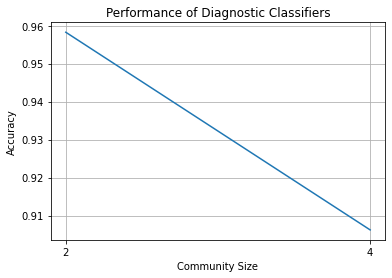

In [7]:
fig, axs = plt.subplots(1,1, sharex = True)

axs.plot(comm_sizes, avg_accs)
axs.grid(True)
axs.set_title('Performance of Diagnostic Classifiers')
axs.set_xticks(comm_sizes)
axs.set_xlabel('Community Size')
axs.set_ylabel('Accuracy')

### Saving Results

In [8]:
with open('./Data/Results/Explor_Analysis/sender_classif_accs.txt', 'a') as file:
    for i,seed_scores in enumerate(accs):
        str_seed_scores = str(seed_scores).replace('[', '').replace(']', '')
        file.write(str_seed_scores + ';' + str(avg_accs[i]) + '\n')

with open('./Data/Results/Explor_Analysis/sender_classif_losses.txt', 'a') as file:
    for i,seed_losses in enumerate(losses):
        str_seed_losses = str(seed_losses).replace('[', '').replace(']', '')
        file.write(str_seed_losses + ';' + str(avg_losses[i]) + '\n')
